In [21]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch
import torch.nn.functional as F
import math
from collections import defaultdict

In [22]:
from ale_py import ALEInterface
ale = ALEInterface()

In [24]:
from ale_py.roms import Skiing
ale.loadROM(Skiing)

In [25]:
from typing import Any, Text

from ale_py.env import gym as ale_gym

# Patch to allow rendering Atari games.
# The AtariEnv's render method expects the mode to be in self._render_mode
# (usually initialized with env.make) instead of taking mode as a param.
_original_atari_render = ale_gym.AtariEnv.render


def atari_render(self, mode: Text = 'rgb_array') -> Any:
  original_render_mode = self._render_mode
  try:
    self._render_mode = mode
    return _original_atari_render(self)
  finally:
    self._render_mode = original_render_mode


ale_gym.AtariEnv.render = atari_render

In [43]:
# env = gym.make('ALE/Skiing-v5', render_mode='human')
env = gym.make('ALE/Skiing-v5', render_mode='rgb_array', full_action_space=False)

In [44]:
from gymnasium.wrappers import RecordVideo

trigger = lambda t: t % 100 == 0

env = RecordVideo(env, video_folder="./videos_sarsa", episode_trigger=trigger, disable_logger=True)

In [28]:
def epsilon_greedy_policy(state, Q, epsilon, n_action):
  probs = torch.ones(n_action) * epsilon / n_action
  best_action = torch.argmax(Q[state]).item()
  probs[best_action] += 1.0 - epsilon
  return torch.multinomial(probs, 1).item()

# def epsilon_greedy_policy(state, Q, epsilon, n_action):
#     if torch.rand(1).item() < epsilon:
#         return torch.randint(0, n_action, (1,)).item()
#     else:
#         return torch.argmax(Q[state]).item()

In [29]:
def softmax_policy(state, Q, temperature):
    logits = Q[state] / temperature
    action_probs = F.softmax(logits, dim=0)
    action = torch.multinomial(action_probs, 1).item()
    return action

In [30]:
def get_pos_player(observe):
    ids = np.where(np.sum(observe == [214, 92, 92], -1) == 3)
    if len(ids[0]) == 0:
        return 0, 0  
    else:
        return int(ids[0].mean()), int(ids[1].mean())

In [31]:
def get_pos_flags(observe):
    if np.any(np.sum(observe == [184, 50, 50], -1) == 3):
        ids = np.where(np.sum(observe == [184, 50, 50], -1) == 3)
        return int(ids[0].mean()), int(ids[1].mean())
    else:
        base = 0
        ids = np.where(np.sum(observe[base:-60] == [66, 72, 200], -1) == 3)
        if len(ids[0]) == 0:
            return 0, 0  
        else:
            return int(ids[0].mean() + base), int(ids[1].mean())

In [32]:
def chebyshev_distance(vec1, vec2): 
      dist = np.max(np.absolute(np.array(vec1) - np.array(vec2)))
      return dist

In [33]:
def manhattan_distance(vec1, vec2):
      dist = sum([np.abs(a - b) for a, b in zip(vec1, vec2)])
      return dist

In [34]:
def euclidian_distance(vec1, vec2):
    dist = math.sqrt((vec1[0] - vec2[0]) ** 2 + (vec1[1] - vec2[1]) ** 2)
    return dist

In [35]:
def calculate_reward(prev_distance, curr_distance):
    if curr_distance < prev_distance:
        return 0
    else:
        return -1

In [41]:
def sarsa(env, gamma, n_episode, alpha, epsilon, temperature=0.1):
  n_action = env.action_space.n
  Q = defaultdict(lambda: torch.zeros(n_action))

  for episode in range(n_episode):
    state = env.reset()
    
    player_pos = get_pos_player(state[0])
    flags_pos = get_pos_flags(state[0])

    distance_frame1 = chebyshev_distance(player_pos, flags_pos)
    
    state = flags_pos[1], player_pos[1]
    is_done = False

    # action = softmax_policy(state, Q, temperature)
    action = epsilon_greedy_policy(state, Q, epsilon, n_action)

    while not is_done:
      # distance = - euclidian_distacne(player_pos, flags_pos)
      # distance = - manhattan_distance(player_pos, flags_pos)
      # distance = - chebyshev_distance(player_pos, flags_pos)
      
      new_state, reward, is_done, _, _ = env.step(action)

      player_pos = get_pos_player(new_state)
      flags_pos = get_pos_flags(new_state)

      distance_frame2 = chebyshev_distance(player_pos, flags_pos)

      new_reward = calculate_reward(distance_frame1, distance_frame2)

      new_state = flags_pos[1], player_pos[1]

      new_action = epsilon_greedy_policy(new_state, Q, epsilon, n_action)
      # new_action = softmax_policy(new_state, Q, temperature)

      td_target = new_reward + gamma * Q[new_state][new_action]
      td_error = td_target - Q[state][action]
      Q[state][action] += alpha * td_error
      
      length_episode[episode] += 1
      total_reward_episode[episode] += reward

      distance_frame1 = distance_frame2
      state = new_state
      action = new_action
    
    print("Episode:", episode, "Total Reward:", total_reward_episode[episode])

  policy = {}
  for state, actions in Q.items():
    policy[state] = torch.argmax(actions).item()

  return Q, policy

In [45]:
n_episode = 1000

length_episode = [0] * n_episode
total_reward_episode = [0] * n_episode

gamma = 0.9
alpha = 0.2
epsilon = 0.05

In [46]:
env.reset()
optimal_Q, optimal_policy = sarsa(env, gamma, n_episode, alpha, epsilon, temperature=0.9)

Episode: 0 Total Reward: -17676.0
Episode: 1 Total Reward: -19915.0
Episode: 2 Total Reward: -18635.0
Episode: 3 Total Reward: -15443.0
Episode: 4 Total Reward: -19812.0
Episode: 5 Total Reward: -18057.0
Episode: 6 Total Reward: -18722.0
Episode: 7 Total Reward: -19792.0
Episode: 8 Total Reward: -15893.0
Episode: 9 Total Reward: -19361.0
Episode: 10 Total Reward: -17686.0
Episode: 11 Total Reward: -17995.0
Episode: 12 Total Reward: -20132.0
Episode: 13 Total Reward: -18414.0
Episode: 14 Total Reward: -18962.0
Episode: 15 Total Reward: -17189.0
Episode: 16 Total Reward: -15927.0
Episode: 17 Total Reward: -14594.0
Episode: 18 Total Reward: -17319.0
Episode: 19 Total Reward: -16696.0
Episode: 20 Total Reward: -18996.0
Episode: 21 Total Reward: -19864.0
Episode: 22 Total Reward: -13720.0
Episode: 23 Total Reward: -21911.0
Episode: 24 Total Reward: -18134.0
Episode: 25 Total Reward: -13692.0
Episode: 26 Total Reward: -18778.0
Episode: 27 Total Reward: -17031.0
Episode: 28 Total Reward: -168

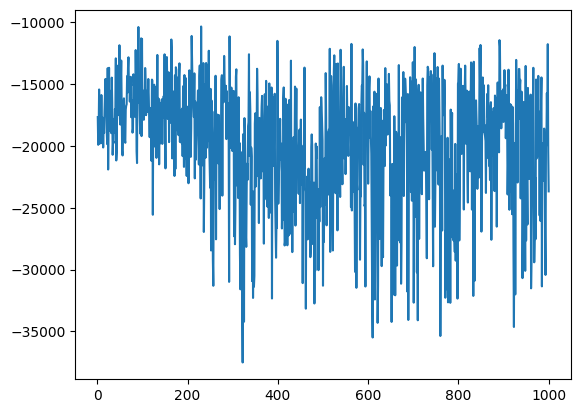

In [47]:
plt.plot(np.arange(1, n_episode + 1), total_reward_episode)
plt.show()

## Точечная оценка J

In [49]:
mean_reward = np.mean(total_reward_episode)
mean_reward

-19783.492

## Интервальная оценка J

95.0% Confidence Interval: [-31786.624999999996, -12630.300000000001]


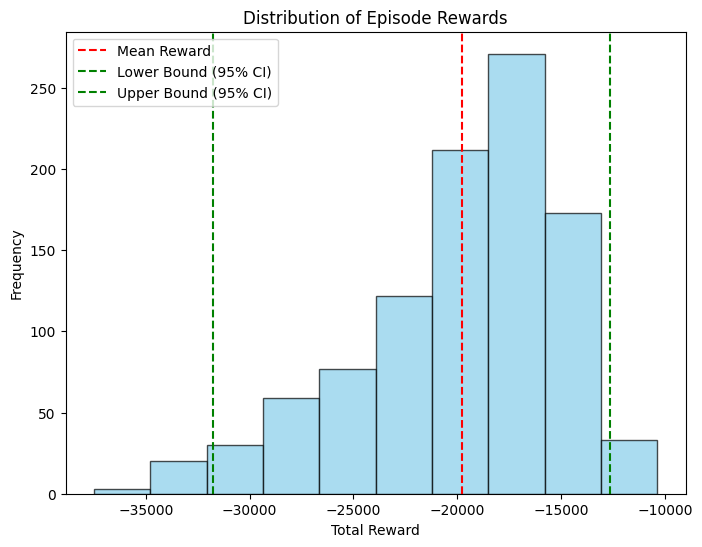

In [50]:
confidence_level = 0.95
lower_percentile = (1 - confidence_level) / 2 * 100
upper_percentile = (1 + confidence_level) / 2 * 100

lower_bound = np.percentile(total_reward_episode, lower_percentile)
upper_bound = np.percentile(total_reward_episode, upper_percentile)

print(f"{confidence_level * 100}% Confidence Interval: [{lower_bound}, {upper_bound}]")

plt.figure(figsize=(8, 6))
plt.hist(total_reward_episode, bins=10, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=mean_reward, color='red', linestyle='--', label='Mean Reward')
plt.axvline(x=lower_bound, color='green', linestyle='--', label='Lower Bound (95% CI)')
plt.axvline(x=upper_bound, color='green', linestyle='--', label='Upper Bound (95% CI)')
plt.xlabel('Total Reward')
plt.ylabel('Frequency')
plt.title('Distribution of Episode Rewards')
plt.legend()
plt.show()

In [51]:
def plot(score, episodes):
  fig, ax = plt.subplots(figsize=(20, 10))

  x = np.asarray(range(episodes + 1))
  y = np.append(np.roll(score, 1), score[episodes - 1])

  ax.set_xlim(1, episodes)
  ax.plot(y, label='Score', color='#d4732f')

  mean = np.mean(score)
  ax.plot(np.asarray([mean for _ in x]), label='Mean={:.4f}'.format(mean))

  state_of_the_art = {
    'Human': -4336.9,
    'ASL DDQN': -8295,
    'DreamerV2': -9299,
    'Advantage Learning': -13264,
    'Rainbow': -28164,
    'Random': -17098.1
  }

  for whom, score in state_of_the_art.items():
      ax.plot(np.asarray([score for _ in range(episodes + 1)]), linestyle='--',
              label='{}={}'.format(whom, score))

  x_no_fill = x[1:]
  y_no_fill = y[1:]
  x_max, y_max = x_no_fill[np.argmax(y_no_fill)], y_no_fill.max()
  x_min, y_min = x_no_fill[np.argmin(y_no_fill)], y_no_fill.min()


  if x_max != x_min:
      max_marker = '*'
      max_color = '#f10202' 
      min_marker = 'X'
      min_color = '#161925'

      ax.scatter(x_max, y_max, label='Episode={}, Max={}'.format(x_max, y_max),
                  color=max_color, s=150, marker=max_marker)
      ax.scatter(x_min, y_min, label='Episode={}, Min={}'.format(x_min, y_min),
                  color=min_color, s=150, marker=min_marker)

  ax.set_title("Total Score vs Episodes", fontsize='x-large')
  ax.legend()
  ax.set_xlabel('Episode', fontsize='large')
  ax.set_ylabel("Score", fontsize='large')

  ax.legend(loc='lower right')

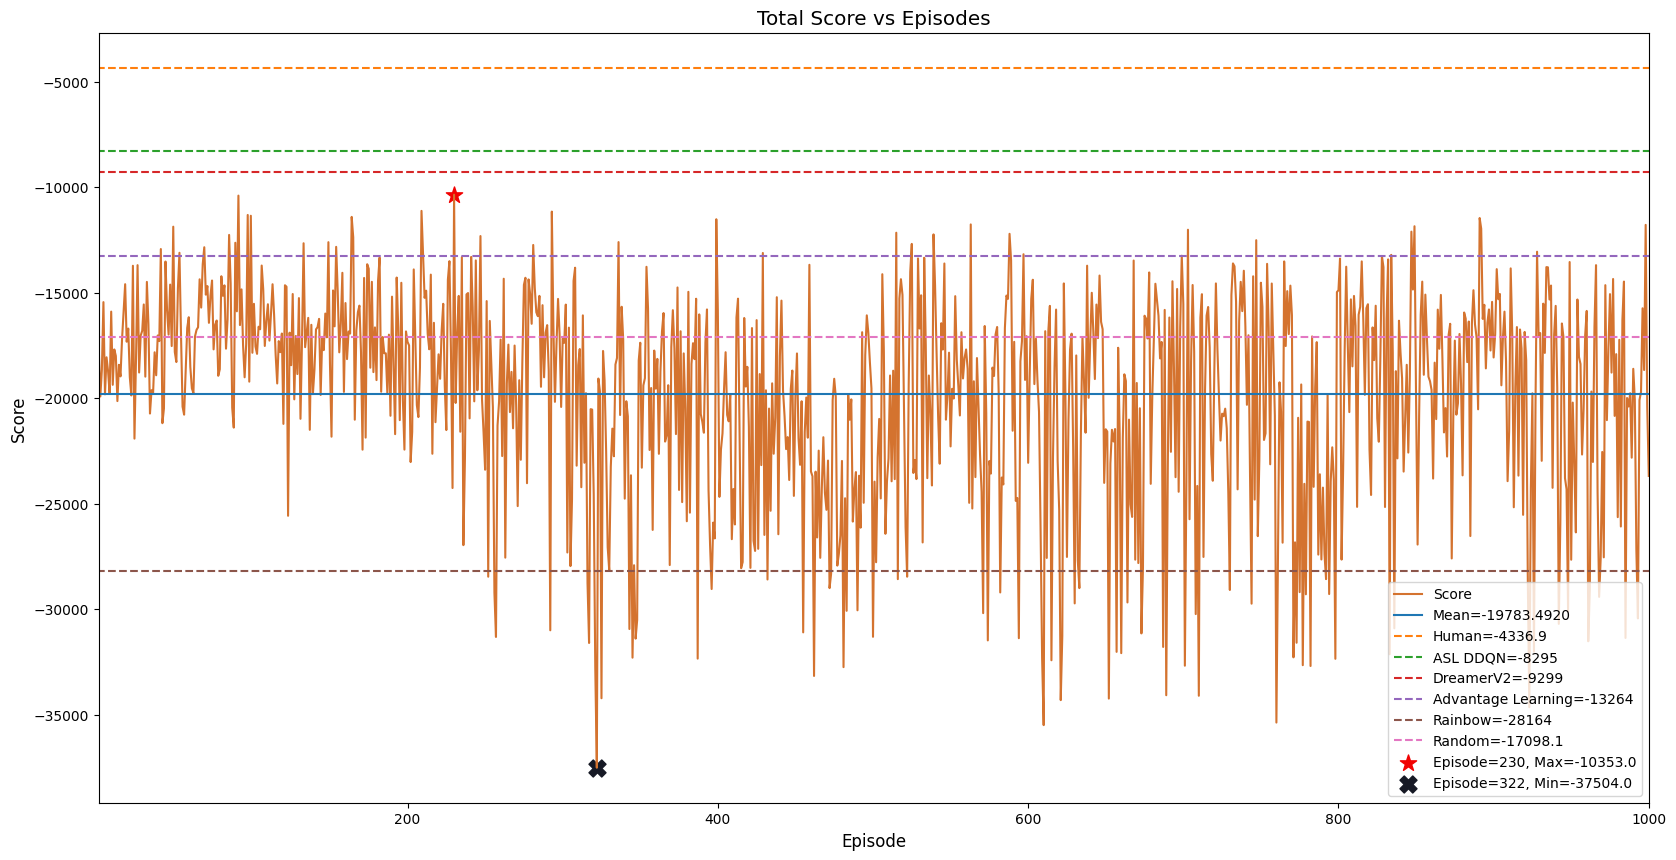

In [52]:
plot(total_reward_episode, 1000)

In [54]:
import random
import numpy as np
episodes = 1000

mean = np.mean(total_reward_episode)
std = np.std(total_reward_episode)

n = (mean ** 2 * std ** 2) / 0.01 ** 2

int(n)

94467966869828452352